# MIRI PSF Photometry #1 - F560W PSF Photometry

**Author**: Ori Fox
<br>
**Last Updated**: March, 2022

## Table of contents
1. [Introduction](#intro)<br>
2. [Setup](#setup)<br>
    2.1 [Python imports](#py_imports)<br>
    2.2 [Plotting functions imports](#matpl_imports)<br>
    2.3 [PSF FWHM dictionary](#psf_fwhm)<br>
3. [Import image to analyze](#data)<br>
    3.1 [Display image](#display_data)<br>
    3.2 [Convert image units and apply pixel area map](#convert_data)<br>
4. [Create a synthetic PSF model (with WebbPSF)](#webbpsf_intro)<br>
    4.1 [Create the single PSF](#single_webbpsf)<br>
    4.2 [Display the single PSF](#display_single_webbpsf)<br>
    4.3 [Create the grid of PSFs](#grid_webbpsf)<br>
    4.4 [Display the grid of PSFs](#display_grid_webbpsf)<br>
5. [Create the PSF model building an effective PSF](#epsf_intro)<br>
    5.1 [Calculate the background](#bkg)<br>
    5.2 [Find sources in the image](#find)<br>
    5.3 [Select sources](#select)<br>
    5.4 [Create catalog of selected sources](#create_cat)<br>
    5.5 [Build the effective PSF](#build_epsf)<br>
    5.6 [Display the effective PSF](#display_epsf)<br>
6. [Perform PSF Photometry](#psf_phot)<br>
    6.1 [PSF photometry output catalog](#psf_cat)<br>
    6.2 [Display residual images](#residual)<br>

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

**Data**: MIRI simulated images obtained using [MIRISIM](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/mirisim) and run through the [JWST pipeline](https://jwst-pipeline.readthedocs.io/en/latest/) of Isochrone of 10-Gyr old population, [Fe/H]=-1 Population placed at 2.5 kpc from the Sun. Salpeter-like IMF, tweaked to have more massive stars (since positions are random, it ensures at least a few bright stars in each image). Kept only sources brighter than J=17 (random cut to speed up MIRISim) and fainter than Ks=10 (to avoid too-bright stars that would have PSF spikes clearly cut by MIRISim in the image)

Here is the [ReadMe](https://stsci.app.box.com/s/2b6evrie2swaybarxhdmpqizktl3g0wm/file/869444882607). All data simulations can be found on [STScI's simulation page](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/simulated-data).

PSF Photometry can be obtained using:

* single PSF model obtained from WebbPSF
* grid of PSF models from WebbPSF
* single effective PSF (ePSF)
* grid of effective PSF (bonus part II)

The notebook shows:

* how to obtain the PSF model from WebbPSF (or build an ePSF)
* how to perform PSF photometry on the image
* how to cross-match the catalogs of the different images (bonus part I)

2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

In this section we import all the necessary python packages and we define some plotting parameters.

### 2.1<font color='white'>-</font>Python imports<a class="anchor" id="py_imports"></a> ###

In [1]:
import os

if not os.environ.get('WEBBPSF_PATH'):
    os.environ['WEBBPSF_PATH'] = '/data/webbpsf-data'

import sys
import time

import numpy as np

import pandas as pd

import glob as glob

import urllib.request

import tarfile

from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.nddata import NDData
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u

from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D
from photutils.detection import DAOStarFinder
from photutils import EPSFBuilder, GriddedPSFModel
from photutils.psf import DAOGroup, extract_stars, IterativelySubtractedPSFPhotometry

import jwst
from jwst.datamodels import ImageModel

import webbpsf
from webbpsf.utils import to_griddedpsfmodel

import pysynphot  # PYSIN_CDBS must be defined in the user's environment (see note below)

from collections import OrderedDict
from astropy.wcs import WCS

In [2]:
#
# General tools
#
import glob
import os
import shutil
import sys
import random
import urllib
import zipfile
#
# Astropy tools
#
from astropy.coordinates import match_coordinates_sky, SkyCoord
from astropy.io import fits, ascii
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.table import Table, Column, vstack
import astropy.units as u
from astropy.visualization import LogStretch, LinearStretch, PercentileInterval, ManualInterval
from astropy.nddata import Cutout2D
#
# JWST models
#
from jwst import datamodels, associations
from jwst.datamodels import ImageModel, dqflags
#
# Matplotlib tools
#
from matplotlib import style, pyplot as plt, rcParams
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
#
# Numpy library
#
import numpy as np
#
# Photutils library and tools
#
import photutils
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils import Background2D, MedianBackground, ModeEstimatorBackground, MMMBackground
#
# Scipy tools
#
from scipy import stats
from scipy.interpolate import CubicSpline
#
# Use 90% of the window width
#
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

2022-03-30 14:34:55,628 - stpipe - WARNING - /var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_53853/2969300567.py:51: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



<div class="alert alert-block alert-info">

**Note on pysynphot**: Data files for pysynphot are distributed separately by Calibration Reference Data System. They are expected to follow a certain directory structure under the root directory, identified by the PYSYN_CDBS environment variable that must be set prior to using this package. In the example below, the root directory is arbitrarily named /my/local/dir/trds/. \
export PYSYN_CDBS=/my/local/dir/trds/ \
See documentation [here](https://pysynphot.readthedocs.io/en/latest/#installation-and-setup) for the configuration and download of the data files.
    
<div >

### 2.2<font color='white'>-</font>Plotting function imports<a class="anchor" id="matpl_imports"></a> ###

<div class="alert alert-block alert-warning">
    <h3><u><b>Warning</b></u></h3>

If the plots in this notebook don't render properly, you may need to install LaTeX. Find more information on a system-wide installation [here](https://www.latex-project.org/get/) and on a Jupyter-specific nbextension [here](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/latex_envs/README.html).
</div>

In [3]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 20

font1 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '12'}
font2 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '20'}

In [4]:
%matplotlib inline
# Figure size
plt.rcParams['figure.figsize'] = [15, 15]
# Figure text and font
plt.rc('text', usetex=True)
plt.rc('font', size=15)

### 2.3<font color='white'>-</font>PSF FWHM dictionary<a class="anchor" id="psf_fwhm"></a> ###

The dictionary contains the NIRCam point spread function (PSF) FWHM, from the [NIRCam Point Spread Function](https://jwst-docs.stsci.edu/near-infrared-camera/nircam-predicted-performance/nircam-point-spread-functions) JDox page. The FWHM are calculated from the analysis of the expected NIRCam PSFs simulated with [WebbPSF](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/psf-simulation-tool). 

**Note**: this dictionary will be updated once the values for the FWHM will be available for each detectors after commissioning.

In [5]:
filters = ['F560W', 'F770W', 'F1000W', 'F1130W', 'F1280W', 'F1500W', 'F1800W', 'F2100W', 'F2550W']

psf_fwhm = [1.636, 2.187, 2.888, 3.318, 3.713, 4.354, 5.224, 5.989, 7.312] #pixls

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i]} for i in range(len(filters))}

### 2.4 Useful Functions

In [6]:
def imshow_me_wcolorbar(img, vmin, vmax, tlabel, xlabel, ylabel, blabel, cmap):
    '''
    Function to show an image.
    
    Inputs
    ----------
    img : 2D numpy.ndarray
        The input 2D array.
    vmin : float
        The minimum value for the colorbar.
    vmax : float
        The maximum value for the colorbar.
    tlabel : string
        The plot title.
    xlabel : string
        The X-axis label.
    ylabel : string
        The Y-axis label.
    blabel : string
        The colorbar label.
    cmap : string
        The name of the colormap.
    '''
    
    fig, ax = plt.subplots()
    cax = ax.imshow(img, vmin=vmin, vmax=vmax, origin='lower', cmap=cmap)
    ax_divider = make_axes_locatable(ax)
    cax1 = ax_divider.append_axes('right', size='3%', pad='2%')
    cb = fig.colorbar(cax, cax=cax1)
    cb.ax.set_ylabel(r'{0}'.format(blabel))
    ax.set_xlabel(r'{0}'.format(xlabel))
    ax.set_ylabel(r'{0}'.format(ylabel))
    ax.set_title(r'{0}'.format(tlabel))
    plt.tight_layout()
    
    return

In [7]:
def imshow_me_wcolorbar_setup(img, vmin, vmax, tlabel, xlabel, ylabel, blabel, cmap):
    '''
    Function to setup an image to show. Similar to imshow_me_wcolorbar,
    but it does not show the image directly, thus allowing to plot
    something else after the call.
    
    Inputs
    ----------
    img : 2D numpy.ndarray
        The input 2D array.
    vmin : float
        The minimum value for the colorbar.
    vmax : float
        The maximum value for the colorbar.
    tlabel : string
        The plot title.
    xlabel : string
        The X-axis label.
    ylabel : string
        The Y-axis label.
    blabel : string
        The colorbar label.
    cmap : string
        The name of the colormap.
    '''
    
    cax = ax.imshow(img, vmin=vmin, vmax=vmax, origin='lower', cmap=cmap)
    ax_divider = make_axes_locatable(ax)
    cax1 = ax_divider.append_axes('right', size='3%', pad='2%')
    cb = fig.colorbar(cax, cax=cax1)
    cb.ax.set_ylabel(r'{0}'.format(blabel))
    ax.set_xlabel(r'{0}'.format(xlabel))
    ax.set_ylabel(r'{0}'.format(ylabel))
    ax.set_title(r'{0}'.format(tlabel))
    
    return

In [8]:
def imshow_cutouts(img, tab, id_sel, xlabel, ylabel, cmap):
    '''
    Function to show four cutouts from an image.
    
    Inputs
    ----------
    img : 2D numpy.ndarray
        The input 2D array.
    tab : Table
        The table with at least (x,y,id) columns.
    id_sel : array(int)
        The ID of the sources in tab to show in the cutouts.
    xlabel : string
        The X-axis label.
    ylabel : string
        The Y-axis label.
    cmap : string
        The name of the colormap.
    '''
    
    fig, ax = plt.subplots(2, 2)

    x, y = tab['x'][tab['id'] == id_sel[0]], tab['y'][tab['id'] == id_sel[0]]
    cutout = Cutout2D(img, (x, y), (51, 51))
    ax[0, 0].imshow(cutout.data, vmin=-0.1, vmax=1.0, origin='lower', cmap=cmap)
    ax[0, 0].scatter(cutout.input_position_cutout[0], cutout.input_position_cutout[1], lw=0.5, s=15, 
                     marker='o', edgecolors='deepskyblue', facecolors='none')
    ax[0, 0].annotate(r'(x,y)$\sim$({0},{1})'.format(int(x[0]), int(y[0])), xy=(0.5, 0.95), xycoords='axes fraction',
                      horizontalalignment='center', verticalalignment='center')
    ax[0, 0].set_xlabel(r'{0}'.format(xlabel))
    ax[0, 0].set_ylabel(r'{0}'.format(ylabel))

    x, y = tab['x'][tab['id'] == id_sel[1]], tab['y'][tab['id'] == id_sel[1]]
    cutout = Cutout2D(img, (x, y), (51, 51))
    ax[0, 1].imshow(cutout.data, vmin=-0.1, vmax=1.0, origin='lower', cmap=cmap)
    ax[0, 1].scatter(cutout.input_position_cutout[0], cutout.input_position_cutout[1], lw=0.5, s=15, 
                     marker='o', edgecolors='deepskyblue', facecolors='none')
    ax[0, 1].annotate(r'(x,y)$\sim$({0},{1})'.format(int(x[0]), int(y[0])), xy=(0.5, 0.95), xycoords='axes fraction', 
                      horizontalalignment='center', verticalalignment='center')
    ax[0, 1].set_xlabel(r'{0}'.format(xlabel))
    ax[0, 1].set_ylabel(r'{0}'.format(ylabel))

    x, y = tab['x'][tab['id'] == id_sel[2]], tab['y'][tab['id'] == id_sel[2]]
    cutout = Cutout2D(img, (x, y), (51, 51))
    ax[1, 0].imshow(cutout.data, vmin=-0.1, vmax=1.0, origin='lower', cmap=cmap)
    ax[1, 0].scatter(cutout.input_position_cutout[0], cutout.input_position_cutout[1], lw=0.5, s=15, 
                     marker='o', edgecolors='deepskyblue', facecolors='none')
    ax[1, 0].annotate(r'(x,y)$\sim$({0},{1})'.format(int(x[0]), int(y[0])), xy=(0.5, 0.95), xycoords='axes fraction', 
                      horizontalalignment='center', verticalalignment='center')
    ax[1, 0].set_xlabel(r'{0}'.format(xlabel))
    ax[1, 0].set_ylabel(r'{0}'.format(ylabel))

    x, y = tab['x'][tab['id'] == id_sel[3]], tab['y'][tab['id'] == id_sel[3]]
    cutout = Cutout2D(img, (x, y), (51, 51))
    ax[1, 1].imshow(cutout.data, vmin=-0.1, vmax=1.0, origin='lower', cmap=cmap)
    ax[1, 1].scatter(cutout.input_position_cutout[0], cutout.input_position_cutout[1], lw=0.5, s=15, 
                     marker='o', edgecolors='deepskyblue', facecolors='none')
    ax[1, 1].annotate(r'(x,y)$\sim$({0},{1})'.format(int(x[0]), int(y[0])), xy=(0.5, 0.95), xycoords='axes fraction', 
                      horizontalalignment='center', verticalalignment='center')
    ax[1, 1].set_xlabel(r'{0}'.format(xlabel))
    ax[1, 1].set_ylabel(r'{0}'.format(ylabel))
    
    plt.tight_layout()
    
    return

In [9]:
def arcsec2pix(x):
    '''
    Function that converts arcsec in MIRIM pixels.
    It is used to setup the secondary axes in a plot.
    
    Inputs
    ----------
    x : float or array(float)
        The value in arcsec.
        
    Outputs
    ----------
    The value(s) in MIRIM pixel.
    '''
    
    return x/0.11

In [10]:
def pix2arcsec(x):
    '''
    Function that converts MIRIM pixels in arcsec.
    It is used to setup the secondary axes in a plot.
    
    Inputs
    ----------
    x : float or array(float)
        The value in MIRIM pixels.
        
    Outputs
    ----------
    The value(s) in arcsec.
    '''
    
    return x*0.11

These last three functions will be used to speed-up the exercise.

In [11]:
def prepare_image(img_name):
    '''
    Function that reads one image, flag all pixels with DQ flags different 
    from [0, 2, 4, 6] and adds a random background gradient.
    To be used in the exercise.
    
    Inputs
    ----------
    img_name : string
        The name of the image.
        
    Outputs
    ----------
    img : ImageModel
        The data model of the image.
    img_mod : 2D numpy.ndarray
        The image data with the additional random background gradient.
    '''
    
    img = datamodels.open(img_name)
    ok = np.zeros(img.data.shape, dtype='int')
    for v in [0, 2, 4, 6]:
        ok = ok + np.where(img.dq == v, 1, 0)

    img.data[ok == 0] = np.nan
    
    x = np.linspace(0, 1, img.meta.subarray.xsize)
    y = np.linspace(0, 1, img.meta.subarray.ysize)
    X, Y = np.meshgrid(x, y)
    if (np.random.rand(1) > 0.5):
        sx = +1
    else:
        sx = -1
    if (np.random.rand(1) > 0.5):
        sy = +1
    else:
        sy = -1
    Z = (10*(np.random.rand(1)-0.5))*np.exp(sx*X/(4+2*(np.random.rand(1)-0.5)))*np.exp(sy*Y/(4+4*(np.random.rand(1)-0.5)))
    
    img_mod = img.data.copy() + Z
    
    _, sky_med, sky_sig = sigma_clipped_stats(img_mod[np.isfinite(img_mod)], sigma=5.0, maxiters=5)
    
    print('')
    print(r' Suggested min value: {0}'.format(sky_med-sky_sig))
    print(r' Suggested max value: {0}'.format(sky_med+sky_sig))
    print('')

    cmin = sky_med-sky_sig
    cmax = sky_med+sky_sig
    
    return img, img_mod, cmin, cmax

In [12]:
def prepare_table(img, xy_tmp, aperture_radius, sky, flux, rad_label):
    '''
    Function that performs additional steps discussed in the notebook.
    To be used in the exercise.
    
    Inputs
    ----------
    img : ImageModel
        The data model of the image.
    xy_tmp : Table
        The table created by DAOStarFinder with the sources detected
        in the image.
    aperture_radius : float
        The aperture radius used for the aperture photometry.
    sky : array(float)
        The array with the local sky background for each source.
    flux : array(float)
        The array with the sky-subtracted flux for each source.
    rad_label : string
        The label for the photometry in the Table.
        
    Outputs
    ----------
    aperture_table : Table
        The final astro-photometric table.
    '''
    
    aperture_table = Table()

    aperture_table['x'] = xy_tmp['xcentroid']
    aperture_table['y'] = xy_tmp['ycentroid']
    aperture_table['sharpness'] = xy_tmp['sharpness']
    aperture_table['roundness1'] = xy_tmp['roundness1']
    aperture_table['roundness2'] = xy_tmp['roundness2']

    aperture_table['id'] = xy_tmp['id']
    
    aperture_table['local_sky_' + rad_label] = sky
    aperture_table['aperture_' + rad_label + '_skysub'] = flux
    
    keep_good = np.logical_and(np.isfinite(aperture_table['aperture_' + rad_label + '_skysub']), 
                               aperture_table['aperture_' + rad_label + '_skysub'] > 0.)
    aperture_table = aperture_table[keep_good]
        
    aperture_table['mag_' + rad_label] = -2.5*np.log10(aperture_table['aperture_' + rad_label + '_skysub'])

    aperture_table['flag_' + rad_label] = np.zeros(len(aperture_table), dtype=int)
    for s in aperture_table:
        jmin = max(1, int(np.floor(s['y']-aperture_radius)))
        jmax = min(round(s['y']+aperture_radius)+1, img.shape[0])
        imin = max(1, int(np.floor(s['x']-aperture_radius)))
        imax = min(round(s['x']+aperture_radius)+1, img.shape[1])
        if (np.sum(img.dq[jmin:jmax, imin:imax] == 6) > 0):
            s['flag_' + rad_label] = 6
        elif (np.sum(img.dq[jmin:jmax, imin:imax] == 2) > 0):
            s['flag_' + rad_label] = 2
        elif (np.sum(img.dq[jmin:jmax, imin:imax] == 4) > 0):
            s['flag_' + rad_label] = 4       

    aperture_table['ra'] = aperture_table['x']
    aperture_table['dec'] = aperture_table['y']
    for a in aperture_table:
        rd = img.meta.wcs.transform("detector", "world", a['x'], a['y'])    
        a['ra'] = rd[0]
        if (a['ra'] > 180):
            a['ra'] -= 360.0
        a['dec'] = rd[1]
        
    return aperture_table

In [13]:
def prepare_phot_cal(cat_name, tmp, sel_radius):
    '''
    Function that cross-matches two catalogs and plot the positional residuals.
    To be used in the exercise.
    
    Inputs
    ----------
    cat_name : string
        The name of the pipeline source catalog
    tmp : Table
        The astro-photometric table.
    sel_radius : float
        The radius for the positional-residual selection in arcsec.
        
    Outputs
    ----------
    calib_cat : Table
        The pipeline source catalog.
    ind_i2d_cat: array(int)
        The array with the indexes from match_sky_coordinates.
    dist_2d: array(float)
        The array with the 2D distances from match_sky_coordinates.
    '''
    
    calib_cat = Table.read(cat_name)

    coord_cal = SkyCoord(ra=tmp['ra'], dec=tmp['dec'], unit="deg")
    coord_i2d = SkyCoord(ra=calib_cat['sky_centroid'].ra.degree, dec=calib_cat['sky_centroid'].dec.degree, unit="deg")
    ind_i2d_cat, dist_2d, a = match_coordinates_sky(coord_cal, coord_i2d)

    delta_ra = 3600.0*(tmp['ra']*np.cos(np.deg2rad(tmp['dec'])) - 
                       calib_cat[ind_i2d_cat]['sky_centroid'].ra.degree * 
                       np.cos(np.deg2rad(calib_cat[ind_i2d_cat]['sky_centroid'].dec.degree)))

    delta_dec = 3600.0*(tmp['dec']-calib_cat[ind_i2d_cat]['sky_centroid'].dec.degree)

    fig, ax = plt.subplots()
    ax.scatter(delta_ra, delta_dec, lw=0.5, s=5, color='black', marker='o')
    circle = plt.Circle((0, 0), sel_radius, color='r', fill=False)
    ax.add_patch(circle)
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.axhline(0, color='red', ls='--')
    ax.axvline(0, color='red', ls='--')
    ax.set_aspect('equal', 'box')
    ax.set_xlabel(r'$\Delta\textrm{(R.A.}\cos\textrm{Dec.) [arcsec]}$')
    ax.set_ylabel(r'$\Delta\textrm{Dec. [arcsec]}$')

    ax2 = ax.secondary_xaxis('top', functions=(arcsec2pix, pix2arcsec))
    ax2.set_xlabel(r'$\Delta\textrm{(R.A.}\cos\textrm{Dec.) [MIRIM pixel]}$')
    ay2 = ax.secondary_yaxis('right', functions=(arcsec2pix, pix2arcsec))
    ay2.set_ylabel(r'$\Delta\textrm{Dec. [MIRIM pixel]}$')

    plt.tight_layout()

    return calib_cat, ind_i2d_cat, dist_2d

We adopted as Background estimator the function [MMMBackground](https://photutils.readthedocs.io/en/stable/api/photutils.background.MMMBackground.html#photutils.background.MMMBackground), which calculates the background in an array using the DAOPHOT MMM algorithm, on the whole image (The background is calculated using a mode estimator of the form `(3 * median) - (2 * mean)`). 

When dealing with a variable background and/or the need to mask the regions where we have no data (for example, if we are analyzing an image with all the 4 NIRCam SW detectors, i.e. containing the chip gaps), we can set `var_bkg = True` and use a more complex algorithm that takes into account those issues.

In [14]:
def calc_bkg(var_bkg=False):
    
    bkgrms = MADStdBackgroundRMS()
    mmm_bkg = MMMBackground()
    im = fits.open(dict_images[det][filt]['images'][0])

    if var_bkg:
        print('Using 2D Background')
        sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
        #coverage_mask = (data == 0)
        
        # Mask all nan or inf pixels
        coverage_mask = np.full(np.shape(im[1].data), False, dtype=bool)
        coverage_mask[np.isnan(im[1].data)] = True
        coverage_mask[~np.isfinite(im[1].data)] = True

        bkg = Background2D(data, (20, 20), filter_size=(30, 30), sigma_clip=sigma_clip, bkg_estimator=mmm_bkg,
                           coverage_mask=coverage_mask, fill_value=0.0)

        data_bkgsub = data.copy()
        data_bkgsub = data_bkgsub - bkg.background

        #_, _, std = sigma_clipped_stats(data_bkgsub)
        std = bkg.background_rms_median

    else:

        std = bkgrms(data)
        bkg = mmm_bkg(data)

        data_bkgsub = data.copy()
        data_bkgsub -= bkg

    return data_bkgsub, std

3.<font color='white'>-</font>Import images to analyze<a class="anchor" id="data"></a>
------------------

We load all the images and we create a dictionary that contains all of them, divided by detectors and filters. This is useful to check which detectors and filters are available and to decide if we want to perform the photometry on all of them or only on a subset.

We retrieve the MIRI detector and filter from the image header.

In [15]:
folder_path = './data/'

if (folder_path == './'):
    print('')
    print(' Please set another folder that is not the main folder.')
    print('')
    pass
elif os.path.isdir(folder_path):
    print('')
    print(' Images and catalogs should be already in \'' + folder_path + 
          '\'. If not, delete the folder and run this cell again.')
    print('')
    pass
elif (os.path.isfile('./stage2-selected.zip') and 
      os.path.isfile('./stage3-selected.zip')):
    # Extract both zip files if they are present
    boxfile = './stage2-selected.zip'
    with zipfile.ZipFile(boxfile) as zf:
        zf.extractall(folder_path)        
    boxfile = './stage3-selected.zip'
    with zipfile.ZipFile(boxfile) as zf:
        zf.extractall(folder_path)
else:
    # Download the data and extract both zip files
    boxlink = 'https://stsci.box.com/shared/static/8pjjn8nnaf1d1mev98ca9kc6mss7prmt.zip'
    boxfile = 'stage2-selected.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    boxlink = 'https://stsci.box.com/shared/static/qstpome9vb95ay6aqlgvk0wvlku9ihay.zip'
    boxfile = 'stage3-selected.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    # Extract both zip files
    boxfile = './stage2-selected.zip'
    with zipfile.ZipFile(boxfile) as zf:
        zf.extractall(folder_path)        
    boxfile = './stage3-selected.zip'
    with zipfile.ZipFile(boxfile) as zf:
        zf.extractall(folder_path)


 Images and catalogs should be already in './data/'. If not, delete the folder and run this cell again.



In [16]:
filter_names = ['F560W', 'F770W']

img_names = {}
cat_names = {}
for f in filter_names:
    print('')
    print(r'{0}-filter images:'.format(f))
    names = glob.glob(folder_path + 'det_*' + f + '*_cal.fits')
    for n in range(len(names)):
        print(r'     {0}) {1}'.format(n+1, names[n]))
    img_names[f] = names
    names = glob.glob(folder_path + 'complex_*' + f + '*cat*.ecsv')
    cat_names[f] = names
    print('')
    print(r'1 catalog found: {0}'.format(names[0]))


F560W-filter images:
     1) ./data/det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits
     2) ./data/det_image_seq2_MIRIMAGE_F560Wexp1_cal.fits
     3) ./data/det_image_seq3_MIRIMAGE_F560Wexp1_cal.fits
     4) ./data/det_image_seq4_MIRIMAGE_F560Wexp1_cal.fits

1 catalog found: ./data/complex_scene_F560W_combined_cat.ecsv

F770W-filter images:
     1) ./data/det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits
     2) ./data/det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits
     3) ./data/det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits
     4) ./data/det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits

1 catalog found: ./data/complex_scene_F770W_combined_cat.ecsv


In [17]:
vals=list(img_names.values())
images=vals[0]+vals[1]
images

['./data/det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits',
 './data/det_image_seq2_MIRIMAGE_F560Wexp1_cal.fits',
 './data/det_image_seq3_MIRIMAGE_F560Wexp1_cal.fits',
 './data/det_image_seq4_MIRIMAGE_F560Wexp1_cal.fits',
 './data/det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits',
 './data/det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits',
 './data/det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits',
 './data/det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits']

In [18]:
dict_images = {'MIRIMAGE': {}}

dict_filter = {}

ff = []
det = []
detlist = []
filtlist = []

for image in images:

    im = fits.open(image)
    f = im[0].header['FILTER']
    d = im[0].header['DETECTOR']
    
    if d == 'MIRIMAGE':
        d = 'MIRIM'

    ff.append(f)
    det.append(d)

    detlist = sorted(list(dict.fromkeys(det)))

    unique_list_filters = []

    for x in ff:

        if x not in unique_list_filters:

            dict_filter.setdefault(x, {})

    for d_s in detlist:
        dict_images[d_s] = dict_filter

    filtlist = sorted(list(dict.fromkeys(dict_filter)))

    if len(dict_images[d][f]) == 0:
        dict_images[d][f] = {'images': [image]}
    else:
        dict_images[d][f]['images'].append(image)

print("Available Detectors:", detlist)
print("Available Filters:", filtlist)

Available Detectors: ['MIRIM']
Available Filters: ['F560W', 'F770W']


**Note**: in this particular example, we analyze each image separately to provide a general overview of the different steps necessary to perform PSF photometry and to highlight the different functions adopted in this notebook.

In [19]:
det = 'MIRIM'
filt = 'F560W'

im = fits.open(dict_images[det][filt]['images'][0])
hdr560 = im["SCI",1].header
w560 = WCS(im["SCI",1].header)

In [20]:
filt

'F560W'

In [21]:
dict_images[det][filt]['images'][0]

'./data/det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits'

In [22]:
dict_images

{'MIRIMAGE': {},
 'MIRIM': {'F560W': {'images': ['./data/det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits',
    './data/det_image_seq2_MIRIMAGE_F560Wexp1_cal.fits',
    './data/det_image_seq3_MIRIMAGE_F560Wexp1_cal.fits',
    './data/det_image_seq4_MIRIMAGE_F560Wexp1_cal.fits']},
  'F770W': {'images': ['./data/det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits',
    './data/det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits',
    './data/det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits',
    './data/det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits']}}}

### 3.1<font color='white'>-</font>Display the image<a class="anchor" id="display_data"></a> ###

To check that our image does not present artifacts and can be used in the analysis, we display it. 

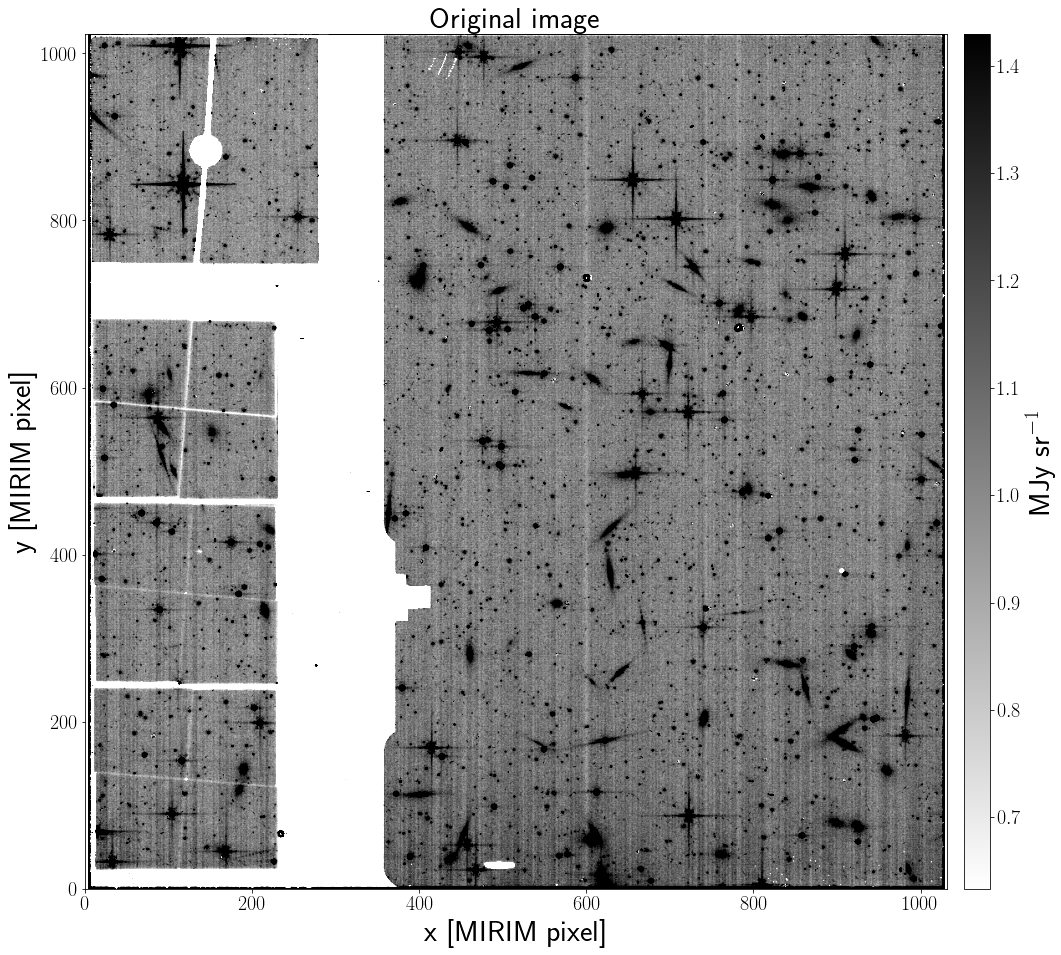

In [23]:
#plt.figure(figsize=(12, 12))
   
data_sb = im[1].data
#ax = plt.subplot(1, 1, 1)
#plt.xlabel("X [px]", fontdict=font2)
#plt.ylabel("Y [px]", fontdict=font2)
#plt.title(filt, fontdict=font2)

_, med, sig = sigma_clipped_stats(data_sb, sigma=5.0, maxiters=5)

# Inputs: 2D array, min value, max value, title, x-axis label, y-axis label, colorbar label, colormap
imshow_me_wcolorbar(data_sb, med-1*sig, med+1*sig, 'Original image', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')

#norm = simple_norm(data_sb, 'sqrt', percent=99.)
#ax.imshow(data_sb, norm=norm, cmap='Greys')
#plt.tight_layout()

### 3.2 Data Quality (DQ) Flags

Not all pixels should be used. We can use the Data Quality (DQ) flags to assess whether a pixel can be considered in calculations or not. [Here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html#data-quality-flags) you can find a description of the DQ flags.

There is no one-size-fits-all solution for selecting pixels using the DQ flags. For this specific exercise, let's keep all pixels with DQ flag equal to:

- 0 = Good pixel
- 2 = Pixel saturated during integration
- 4 = Jump detected during integration
- 6 = Combination of DQ flags 2 and 4

As we can see, the DQ flags can correspond to multiple features. We can use _dqflags.dqflags_to_mnemonics_ to convert the DQ integer values into more user-friendly names:

In [24]:
print(r' DQ flag equal to 2: {0}'.format(dqflags.dqflags_to_mnemonics(2, dqflags.group)))
print(r' DQ flag equal to 4: {0}'.format(dqflags.dqflags_to_mnemonics(4, dqflags.group)))
print(r' DQ flag equal to 6: {0}'.format(dqflags.dqflags_to_mnemonics(6, dqflags.group)))

 DQ flag equal to 2: {'SATURATED'}
 DQ flag equal to 4: {'JUMP_DET'}
 DQ flag equal to 6: {'JUMP_DET', 'SATURATED'}


Let's flag all pixels with a DQ flag different from these four values:

Third extension is the DQ flags
https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html#rate

In [25]:
ok = np.zeros(im[1].data.shape, dtype='int')
for v in [0, 2, 4, 6]:
    ok = ok + np.where(im[3].data == v, 1, 0)

im[1].data[ok == 0] = np.nan
print(r'{0} out of {1} pixels are not usable (~{2:3.1f}%)'.format((ok == 0).sum(), im[1].data.shape[0]*im[1].data.shape[1], 
                                                                  (ok == 0).sum()/(im[1].data.shape[0]*im[1].data.shape[1])*100.0))

311387 out of 1056768 pixels are not usable (~29.5%)


After masking, the same MIRI image looks different:

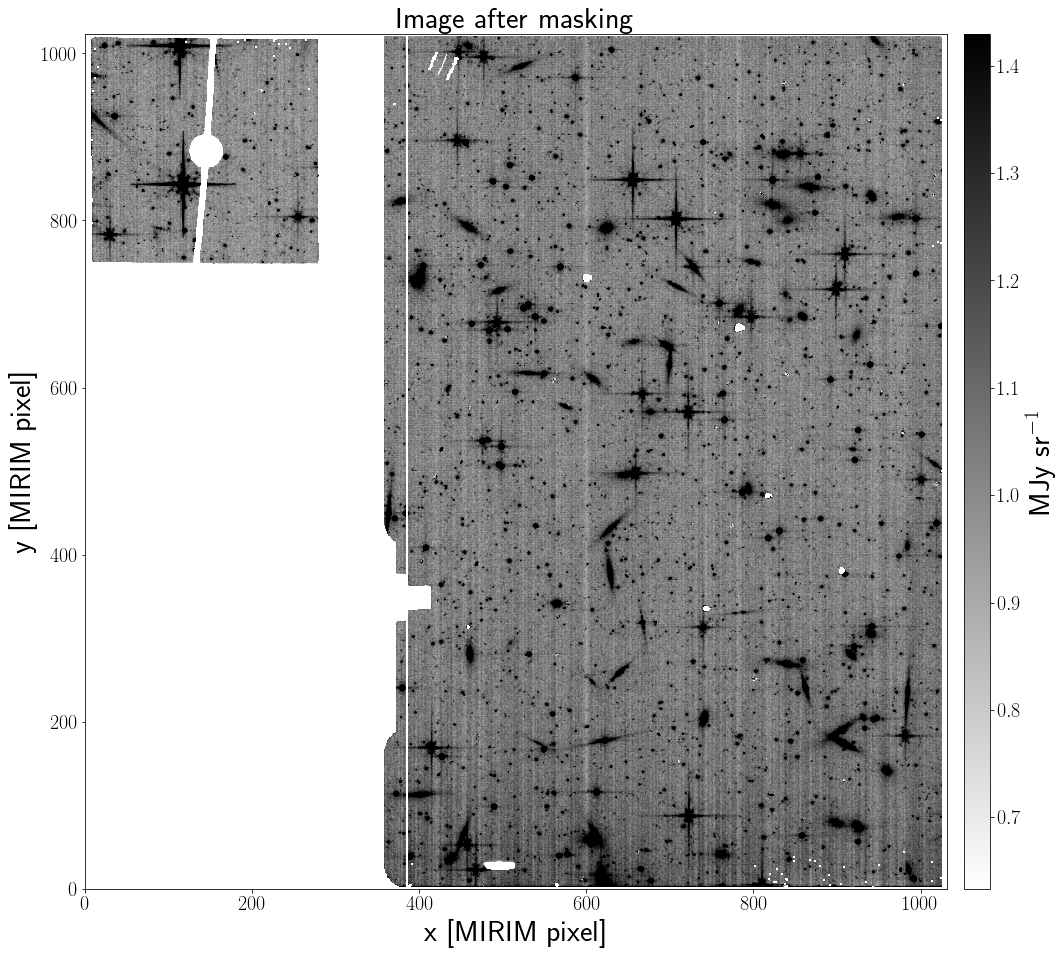

In [26]:
imshow_me_wcolorbar(im[1].data, med-1*sig, med+1*sig, 'Image after masking', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')

As we can notice, the regions associated to the 4-quadrant phase mask (4QPM) coronagraphs disappeared from the image. The optical system of the 4QPM coronographs is different from that of the imager. Because of the way these optical elements affect the light transmission, the calibration of the 4QPM-coronograph regions is complicated and specific for these coronographs. Therefore, even though photons are detected in the regions of the coronagraphs during standard imaging observations, these regions should not be used while analyzing the Stage-2 image. If you run the _calwebb_image3_ pipeline (or the resample step in _calwebb_image2_), you will notice that the 4QPM regions are missing in the resampled image (_i2d.fits_) as well.

Another feature we can notice is that two columns (# 385 and 386) were flagged. Although a qualitative assessment of the image (for example with ds9) does not show anything particularly different from the other columns, these two columns showed to be coupled and should not be used for science.

### 3.2<font color='white'>-</font>Convert image units and apply pixel area map<a class="anchor" id="convert_data"></a> ###

The unit of the Level-2 and Level-3 Images from the pipeline is MJy/sr (hence a surface brightness). The actual unit of the image can be checked from the header keyword **BUNIT**. The scalar conversion constant is copied to the header keyword **PHOTMJSR**, which gives the conversion from DN/s to megaJy/steradian. For our analysis we revert back to DN/s.

For images that have not been transformed into a distortion-free frame (i.e. not drizzled), a correction must be applied to account for the different on-sky pixel size across the field of view. A pixel area map (PAM), which is an image where each pixel value describes that pixel's area on the sky relative to the native plate scale, is used for this correction. In the stage 2 of the JWST pipeline, the PAM is copied into an image extension called **AREA** in the science data product. 

In [27]:
imh = im[1].header
data = data_sb / imh['PHOTMJSR']
print('Conversion factor from {units} to DN/s for filter {f}:'.format(units=imh['BUNIT'], f=filt), imh['PHOTMJSR'])
area = im[4].data
data = data * area

Conversion factor from MJy/sr to DN/s for filter F560W: 1.127009987831116


4.<font color='white'>-</font>Create synthetic PSF (with WebbPSF) <a class="anchor" id="webbpsf_intro"></a>
------------------

WebbPSF is a Python package that computes simulated PSFs for NASA’s JWST and Nancy Grace Roman Space Telescope (formerly WFIRST). WebbPSF transforms models of telescope and instrument optical state into PSFs, taking into account detector pixel scales, rotations, filter profiles, and point source spectra. It is not a full optical model of JWST, but rather a tool for transforming optical path difference (OPD) maps, created with some other tool, into the resulting PSFs as observed with JWST’s or Roman’s instruments. For a full documentation on WebbPSF, see [here](https://webbpsf.readthedocs.io/en/latest/) and for is capability and limitation, see [here](https://webbpsf.readthedocs.io/en/latest/intro.html).

The function below allows to create a single PSF or a grid of PSFs (the PSF can also be saved as a fits file). First, we need to specify the instrument (MIRI), detector, and filter. Then, to create a single (or grid) PSF we use the webbPSF method *psf_grid*, which will output a (list of or single) photutils GriddedPSFModel object(s). A tutorial notebook on the *psf_grid* method can be found [here](https://github.com/spacetelescope/webbpsf/blob/stable/notebooks/Gridded_PSF_Library.ipynb).

**Important Parameters**:

* `num`: the total number of fiducial PSFs to be created and saved in the files. This
    number must be a square number (4, 9, 16, etc.)

* `oversample`: the oversample factor we want to adopt in the PSF creation.

* `fov`: the size in pixel of the PSF model. The size depends on the shape of the PSF and how much flux is contained in the wings of the PSFs (i.e., a small field of view will exclude more flux from the PSF wings). However, increasing the field of view, increase also the computational time, so we need to find a reasonable compromise.

* `source`: the source spectrum we want to adopt. Source spectra are defined using the function  `webbpsf.specFromSpectralType` where we need to define the spectral type and the model library (e.g., webbpsf.specFromSepectralType('G5V', catalog='phoenix')). See also note below on the default spectrum depending on if pysynphot is installed or not. 

* `all_detectors`: run all detectors for the instrument. Since we analyze only 1 detector, we set `all_detectors = False` (we do not need to create a PSF model for all MIRI detectors).

* `use_detsampled_psf`: If the grid of PSFs returned will be detector sampled (made by binning down the oversampled PSF) or oversampled by the factor defined by the oversample. For our analysis, we want to create an oversampled PSF model, so we set `use_detsampled_psf = False`.

<div class="alert alert-block alert-info">
    
**Note on centering**: by default, the PSF will be centered at the exact center of the output array. This means that if the PSF is computed on an array with an odd number of pixels, the PSF will be centered exactly on the central pixel. If the PSF is computed on an array with even size, it will be centered on the “crosshairs” at the intersection of the central four pixels.

**Note on normalization**: by default, PSFs are normalized to total intensity = 1.0 at the entrance pupil (i.e. at the JWST OTE primary). A PSF calculated for an infinite aperture would thus have integrated intensity =1.0. A PSF calculated on any smaller finite subarray will have some finite encircled energy less than one.

**Note on source spectrum**: The default source spectrum is, if *pysynphot* is installed, a G2V star spectrum from Castelli & Kurucz (2004). Without *pysynphot*, the default is a simple flat spectrum such that the same number of photons are detected at each wavelength.

</div>

In [28]:
def create_psf_model(det='MIRIM', filt='F770W', fov=101, source=None, create_grid=False, num=9, save_psf=False, 
                     detsampled=False):

    miri = webbpsf.MIRI()

    miri.detector = det 
    miri.filter = filt

    print("Using a {field}".format(field=fov), "px fov")

    if create_grid:
        print("")
        print("Creating a grid of PSF for filter {filt} and detector {det}".format(filt=filt, det=det))
        print("")
        num = num
        
        if save_psf:
            
            outname = 'PSF_%s_samp4_fov%d_npsfs%d.fits' % (filt, fov, num)
            psf = miri.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov, 
                               save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=detsampled)

        else:
        
            psf = miri.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov, 
                               use_detsampled_psf=detsampled)
            
    else:
        print("")
        print("Creating a single PSF for filter {filt} and detector {det}".format(filt=filt, det=det))
        print("")
        num = 1
        
        if save_psf:

            outname = 'PSF_%s_samp4_fov%d_npsfs%d.fits' % (filt, fov, num)
            psf = miri.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov, 
                               save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=detsampled)
        
        else:
      
            psf = miri.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov, 
                               use_detsampled_psf=detsampled)
        
    return psf     

### 4.1<font color='white'>-</font>Create the single PSF<a class="anchor" id="single_webbpsf"></a> ###

In [29]:
psfs_dir = 'PSF_MODELS/'

if not os.path.exists(psfs_dir):
    os.makedirs(psfs_dir)

psf_webbpsf_single = create_psf_model(det=det, filt=filt, fov=11, source=None, create_grid=False, save_psf=True, 
                                      detsampled=False)

Using a 11 px fov

Creating a single PSF for filter F560W and detector MIRIM


Running instrument: MIRI, filter: F560W
  Running detector: MIRIM
    Position 1/1: (511, 511) pixels


2022-03-30 14:36:20,378 - stpipe - WARNING - /Users/ofox/miniconda3/envs/jwebbinar/lib/python3.8/site-packages/astropy/io/fits/card.py:1009: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',



  Saving file: PSF_MODELS/PSF_F560W_samp4_fov11_npsfs1_mirim.fits


### 4.2<font color='white'>-</font>Display the single PSF<a class="anchor" id="display_single_webbpsf"></a> ###

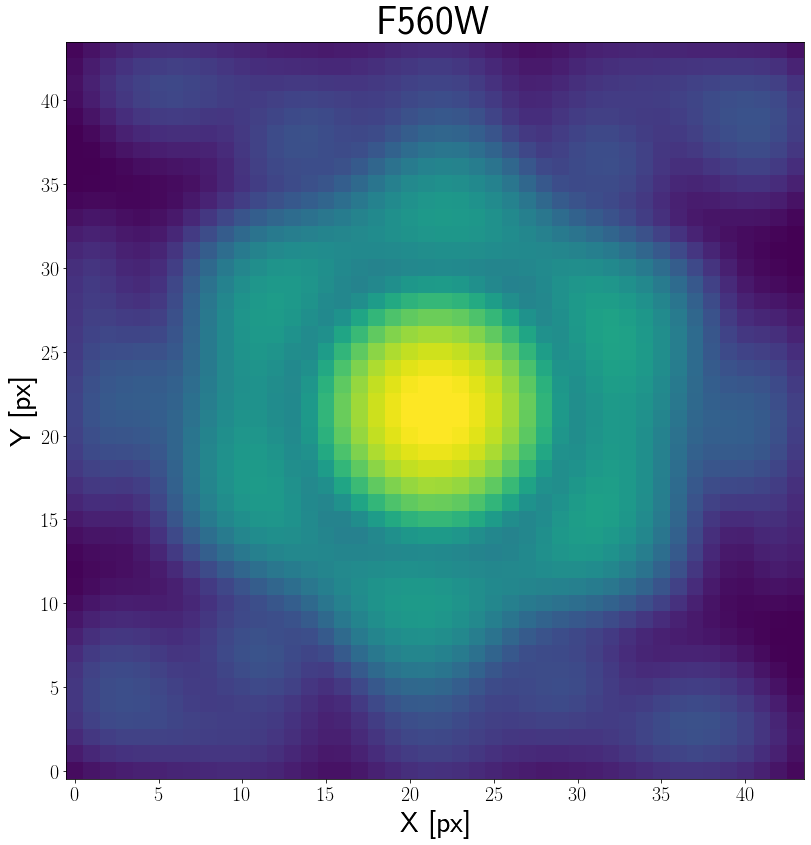

In [30]:
plt.figure(figsize=(12, 12))

ax = plt.subplot(1, 1, 1)

norm_psf = simple_norm(psf_webbpsf_single.data[0], 'log', percent=99.)
ax.set_title(filt, fontsize=40)
ax.imshow(psf_webbpsf_single.data[0], norm=norm_psf)
ax.set_xlabel('X [px]', fontsize=30)
ax.set_ylabel('Y [px]', fontsize=30)
plt.tight_layout()

### 4.3<font color='white'>-</font>Create the grid of PSFs<a class="anchor" id="grid_webbpsf"></a> ###

In [31]:
psf_webbpsf_grid = create_psf_model(det=det, filt=filt, fov=11, source=None, create_grid=True, num=16, 
                                    save_psf=True, detsampled=False)

Using a 11 px fov

Creating a grid of PSF for filter F560W and detector MIRIM


Running instrument: MIRI, filter: F560W
  Running detector: MIRIM
    Position 1/16: (0, 0) pixels


2022-03-30 14:36:32,425 - stpipe - WARNING - /Users/ofox/miniconda3/envs/jwebbinar/lib/python3.8/site-packages/webbpsf/opds.py:1739: UserWarning: For (V2,V3) = [-6.36393735 -7.26974788] arcmin, Field point -6.363937347326865 arcmin, -0.5632056 arcmin not within valid region for field dependence model of OTE WFE for MIRI: -8.254199999999999 arcmin--6.21738 arcmin, -2.557224 arcmin--0.5632056 arcmin. Clipping to closest available valid location, 0.03295348152304289 arcmin away from the requested coordinates.
  warnings.warn(f'For (V2,V3) = {v2v3}, Field point {x_field_pt}, {y_field_pt} not within valid region for field dependence model of OTE WFE for {instrument}: {min_x_field}-{max_x_field}, {min_y_field}-{max_y_field}. Clipping to closest available valid location, {clip_dist} away from the requested coordinates.')



    Position 2/16: (0, 341) pixels
    Position 3/16: (0, 682) pixels
    Position 4/16: (0, 1023) pixels
    Position 5/16: (341, 0) pixels
    Position 6/16: (341, 341) pixels
    Position 7/16: (341, 682) pixels
    Position 8/16: (341, 1023) pixels
    Position 9/16: (682, 0) pixels
    Position 10/16: (682, 341) pixels
    Position 11/16: (682, 682) pixels
    Position 12/16: (682, 1023) pixels
    Position 13/16: (1023, 0) pixels
    Position 14/16: (1023, 341) pixels
    Position 15/16: (1023, 682) pixels
    Position 16/16: (1023, 1023) pixels


2022-03-30 14:38:01,490 - stpipe - WARNING - /Users/ofox/miniconda3/envs/jwebbinar/lib/python3.8/site-packages/astropy/io/fits/card.py:1009: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',



  Saving file: PSF_MODELS/PSF_F560W_samp4_fov11_npsfs16_mirim.fits


### 4.4<font color='white'>-</font>Display the grid of PSFs<a class="anchor" id="display_grid_webbpsf"></a> ###

We show the grid of PSFs with their positions in detector coordinates and the difference from the mean to highlight the differences between the different models. We use the webbPSF function *gridded_library.display_psf_grid*.

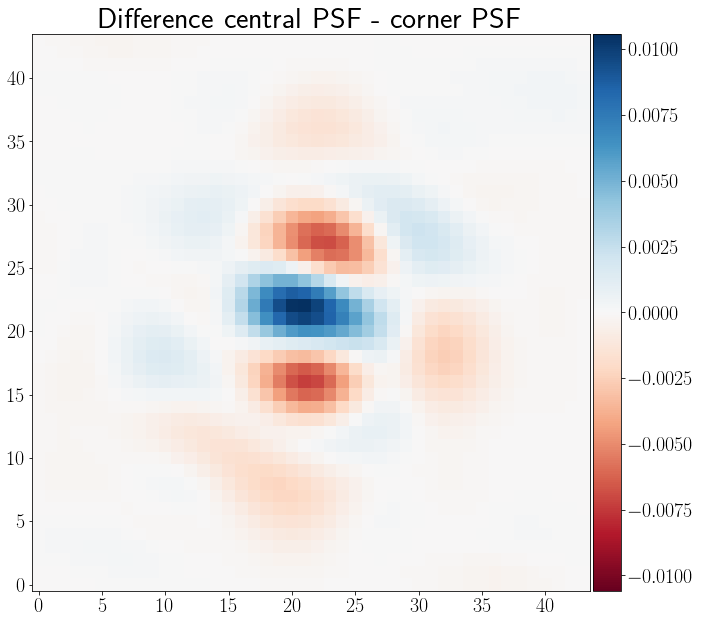

In [32]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
plt.title('Difference central PSF - corner PSF')        
model1 = psf_webbpsf_single.data[0]
model2 = psf_webbpsf_grid.data[0]

ratio = (model1 - model2)
aa = np.max(np.abs(ratio))
divider = make_axes_locatable(ax)
im = ax.imshow(ratio, origin='lower', vmin=-aa, vmax=aa, cmap='RdBu')
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.tight_layout()

5.<font color='white'>-</font>Create PSF model building an effective PSF<a class="anchor" id="epsf_intro"></a>
------------------

More information on the PhotUtils Effective PSF can be found [here](https://photutils.readthedocs.io/en/stable/epsf.html).

The process of creating an effective PSF can be summarized as follows:

* Find the stars in the image.
* Select the stars we want to use for building the effective PSF. 
* Build the effective PSF.

### 5.1<font color='white'>-</font>Calculate the background<a class="anchor" id="bkg"></a> ###

Defined above

### 5.2<font color='white'>-</font>Find sources in the image<a class="anchor" id="find"></a> ###

To find sources in the image, we use the [DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html) function. 

[DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html) detects stars in an image using the DAOFIND ([Stetson 1987](https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract)) algorithm. DAOFIND searches images for local density maxima that have a peak amplitude greater than `threshold` (approximately; threshold is applied to a convolved image) and have a size and shape similar to the defined 2D Gaussian kernel.

**Important parameters**:

* `threshold`: The absolute image value above which to select sources.
* `fwhm`: The full-width half-maximum (FWHM) of the major axis of the Gaussian kernel in units of pixels.

In [33]:
def find_stars(det='MIRIM', filt='F770W', threshold=3, var_bkg=False):
    
    print('Finding stars --- Detector: {d}, Filter: {f}'.format(f=filt, d=det))

    sigma_psf = dict_utils[filt]['psf fwhm']

    print('FWHM for the filter {f}:'.format(f=filt), sigma_psf, "px")
    
    data_bkgsub, std = calc_bkg(var_bkg=True)
    
    daofind = DAOStarFinder(threshold=threshold * std, fwhm=sigma_psf, exclude_border=True)
    found_stars = daofind(data_bkgsub)
    
    print('')
    print('Number of sources found in the image:', len(found_stars))
    print('-------------------------------------')
    print('')
    
    return data_bkgsub, found_stars

In [34]:
det = 'MIRIM'
filt = 'F560W'

im = fits.open(dict_images[det][filt]['images'][0])
hdr560 = im["SCI",1].header
w560 = WCS(im["SCI",1].header)

In [35]:
tic = time.perf_counter()

data_bkgsub, found_stars = find_stars(det=det, filt=filt, threshold=5, var_bkg=True)

toc = time.perf_counter()

print("Elapsed Time for finding stars:", toc - tic)

2022-03-30 14:38:31,589 - stpipe - WARNING - /Users/ofox/miniconda3/envs/jwebbinar/lib/python3.8/site-packages/photutils/background/background_2d.py:282: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically masked.
  warnings.warn('Input data contains invalid values (NaNs or '



Finding stars --- Detector: MIRIM, Filter: F560W
FWHM for the filter F560W: 1.636 px
Using 2D Background

Number of sources found in the image: 1778
-------------------------------------

Elapsed Time for finding stars: 1.0392166369999813


In [36]:
# Print 10 lines of the table
found_stars.pprint_all(max_lines=10)

 id      xcentroid         ycentroid          sharpness           roundness1           roundness2      npix sky         peak               flux                mag         
---- ----------------- ------------------ ------------------ -------------------- -------------------- ---- --- ------------------- ------------------ --------------------
   1 798.7024095246055   4.98242537349245 0.7430168068757229   0.3217484084797292  0.07243444427591843   25 0.0  0.5179730606282563 1.1198773010659837 -0.12292610491410838
   2 660.4131528442464  7.737473968803516 0.7232724856518941 -0.16117853431342113   0.4059661967982779   25 0.0  0.8334592103209456  2.128476887906125  -0.8201723468662441
   3  720.604630824141  6.894440104738175 0.8159941714958663 -0.12289701206197626  0.18865711365787682   25 0.0  0.6043118684844987  1.673977077492353  -0.5593737667793902
 ...               ...                ...                ...                  ...                  ...  ... ...                 ...         

The column description is almost straightforward. The three parameters that need further description are:
- sharpness : (height of the central pixel - mean of the surrounding non-bad pixels) / (height of the best fitting Gaussian function at that point);
- roundness1 : source symmetry;
- roundness2 : (difference in the height of the best fitting Gaussian function in x - the height of the the best fitting Gaussian function in y) / (average of the best fitting Gaussian functions in x and y).

These parameters can be used to discern between stars, galaxies or spurious detections. It is possible to setup _DAOStarFinder_ to exclude a priori objects outside a specific range of sharpness/roundness1/roundness2. Finally, note that the magnitude is defined as $-2.5\log_{10}(\text{peak density/detection threshold})$, which is just a rough estimate of the magnitude. An exaustive description of inputs and outputs is also provided [here](https://iraf.net/irafhelp.php?val=daofind).

Let's plot what we have found. We can use _imshow_me_wcolorbar_setup_, which is a function similar to _imshow_me_wcolorbar_ we used before but it allows us to keep plotting.

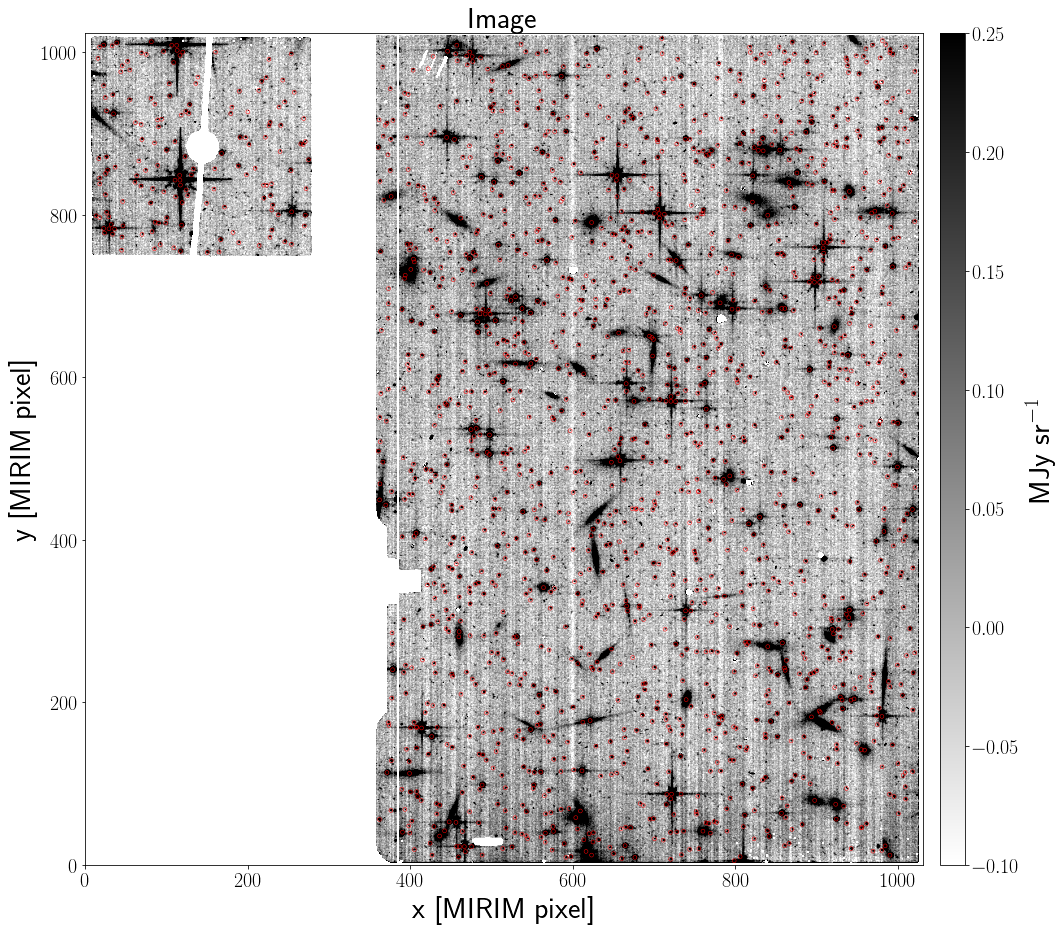

In [37]:
fig, ax = plt.subplots()
imshow_me_wcolorbar_setup(data_bkgsub, -0.1, 0.25, 'Image', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')
ax.scatter(found_stars['xcentroid'], found_stars['ycentroid'], lw=0.5, s=15, marker='o', edgecolors='red', facecolors='none')
plt.tight_layout()

### 5.3<font color='white'>-</font>Select sources<a class="anchor" id="select"></a> ###

At the beginning, we used the DQ flags to mask some pixels and kept only those with DQ$=$0, 2, 4, 6. Although still perfectly usable, you might want to keep track of pixels that saturated during an integration or were hit by a cosmic ray. For this reason, we define a flag by checking all pixels within each aperture radius we used:

In [38]:
found_stars['flags'] = np.zeros(len(found_stars), dtype=int)

rad = 5.

for s in found_stars:
        jmin = max(1, int(np.floor(s['ycentroid']-rad)))
        jmax = min(round(s['ycentroid']+rad)+1, im[1].shape[0])
        imin = max(1, int(np.floor(s['xcentroid']-rad)))
        imax = min(round(s['xcentroid']+rad)+1, im[1].shape[1])
        if (np.sum(im[3].data[jmin:jmax, imin:imax] == 6) > 0):
            s['flags'] = 6
        elif (np.sum(im[3].data[jmin:jmax, imin:imax] == 2) > 0):
            s['flags'] = 2
        elif (np.sum(im[3].data[jmin:jmax, imin:imax] == 4) > 0):
            s['flags'] = 4
            
print('                            Sources found: {0}'.format(len(found_stars)))
print('Sources with "SATURATED" pixels within rad=5: {0}'.format(np.sum(np.logical_or(found_stars['flags'] == 2, found_stars['flags'] == 6))))
print(' Sources with "JUMP_DET" pixels within rad=5: {0}'.format(np.sum(np.logical_or(found_stars['flags'] == 4, found_stars['flags'] == 6))))

                            Sources found: 1778
Sources with "SATURATED" pixels within rad=5: 1
 Sources with "JUMP_DET" pixels within rad=5: 493


Let's check if our flag works. For example, let's test the jump-detection flag:

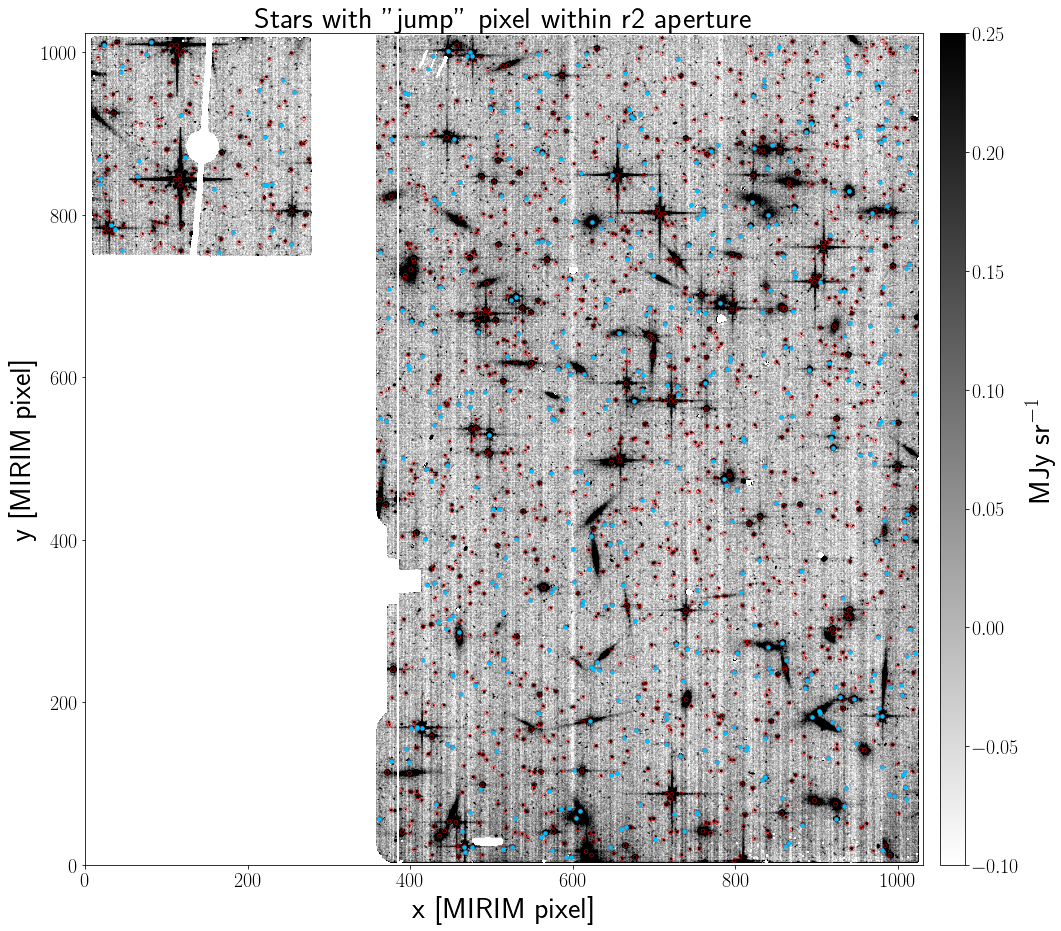

In [39]:
# Flag for stars with "jump" pixel within rad=5 aperture
jump = np.logical_or(found_stars['flags'] == 4, found_stars['flags'] == 6)

fig, ax = plt.subplots()
imshow_me_wcolorbar_setup(data_bkgsub, -0.1, 0.25, 'Stars with "jump" pixel within r2 aperture', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')
ax.scatter(found_stars['xcentroid'], found_stars['ycentroid'], lw=0.5, s=15, marker='o', edgecolors='red', facecolors='none')
ax.scatter(found_stars['xcentroid'][jump], found_stars['ycentroid'][jump], c='deepskyblue', lw=0, s=20)
plt.tight_layout()

We can adopt different methods to select sources we want to use to build an effective PSF. Here, we select objects applying a brightness cut (we do not want to include objects that are too faint) and using the `roundness2` and `sharpness` parameters provided in the [DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html) output catalog.

`roundness2` measures the ratio of the difference in the height of the best fitting Gaussian function in x minus the best fitting Gaussian function in y, divided by the average of the best fitting Gaussian functions in x and y.

`sharpness` measures the ratio of the difference between the height of the central pixel and the mean of the surrounding non-bad pixels in the convolved image, to the height of the best fitting Gaussian function at that point.

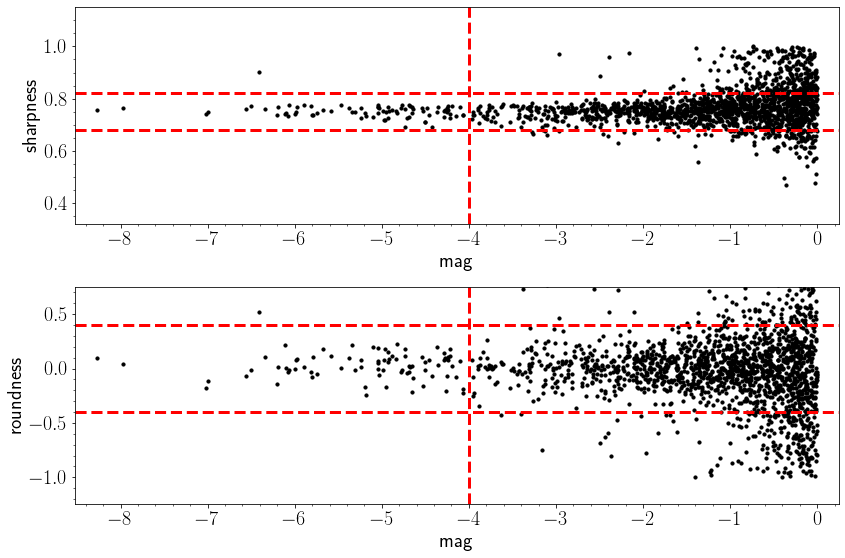

In [40]:
plt.figure(figsize=(12, 8))
plt.clf()

ax1 = plt.subplot(2, 1, 1)

ax1.set_xlabel('mag', fontdict=font2)
ax1.set_ylabel('sharpness', fontdict=font2)

xlim0 = np.min(found_stars['mag']) - 0.25
xlim1 = np.max(found_stars['mag']) + 0.25
ylim0 = np.min(found_stars['sharpness']) - 0.15
ylim1 = np.max(found_stars['sharpness']) + 0.15

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(found_stars['mag'], found_stars['sharpness'], s=10, color='k')

sh_inf = 0.68
sh_sup = 0.82
mag_lim = -4.0

ax1.plot([xlim0, xlim1], [sh_sup, sh_sup], color='r', lw=3, ls='--')
ax1.plot([xlim0, xlim1], [sh_inf, sh_inf], color='r', lw=3, ls='--')
ax1.plot([mag_lim, mag_lim], [ylim0, ylim1], color='r', lw=3, ls='--')

ax2 = plt.subplot(2, 1, 2)

ax2.set_xlabel('mag', fontdict=font2)
ax2.set_ylabel('roundness', fontdict=font2)

ylim0 = np.min(found_stars['roundness2']) - 0.25
ylim1 = np.max(found_stars['roundness2']) - 0.25

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

round_inf = -0.40
round_sup = 0.40

ax2.scatter(found_stars['mag'], found_stars['roundness2'], s=10, color='k')

ax2.plot([xlim0, xlim1], [round_sup, round_sup], color='r', lw=3, ls='--')
ax2.plot([xlim0, xlim1], [round_inf, round_inf], color='r', lw=3, ls='--')
ax2.plot([mag_lim, mag_lim], [ylim0, ylim1], color='r', lw=3, ls='--')

plt.tight_layout()

### 5.4<font color='white'>-</font>Create catalog of selected sources<a class="anchor" id="create_cat"></a> ###

We can also include a separation criteria if we want to retain in the final catalog only the stars that are well isolated. In particular, we can select only the stars that do not have a neighbour closer than X pixel, where X is a parameter that can be set manually.

**Note**: The magnitude limit and the minimum distance to the closest neighbour depend on the user science case (i.e.; number of stars in the field of view, crowding, number of bright sources, minimum number of stars required to build the ePSF, etc.) and must be modified accordingly.

In [41]:
mask = ((found_stars['mag'] < mag_lim) & (found_stars['roundness2'] > round_inf)
        & (found_stars['roundness2'] < round_sup) & (found_stars['sharpness'] > sh_inf) 
        & (found_stars['sharpness'] < sh_sup))

found_stars_sel = found_stars[mask]
found_stars_sel_f560w = found_stars_sel

print('Number of stars selected to build ePSF:', len(found_stars_sel))

# if we include the separation criteria:

d = []

# we do not want any stars in a 10 px radius. 

min_sep = 10

x_tot = found_stars['xcentroid']
y_tot = found_stars['ycentroid']

for xx, yy in zip(found_stars_sel['xcentroid'], found_stars_sel['ycentroid']):

    sep = []
    dist = np.sqrt((x_tot - xx)**2 + (y_tot - yy)**2)
    sep = np.sort(dist)[1:2][0]
    d.append(sep)

found_stars_sel['min distance'] = d
mask_dist = (found_stars_sel['min distance'] > min_sep)

found_stars_sel2 = found_stars_sel[mask_dist]
found_stars_sel2_fw = found_stars_sel2

print('Number of stars selected to build ePSF \
including "mimimum distance closest neighbour" selection):', len(found_stars_sel2))

Number of stars selected to build ePSF: 81
Number of stars selected to build ePSF including "mimimum distance closest neighbour" selection): 31


### 5.5<font color='white'>-</font>Build the effective PSF<a class="anchor" id="build_epsf"></a> ###

We Build the effective PSF using [EPSBuilder](https://photutils.readthedocs.io/en/stable/api/photutils.psf.EPSFBuilder.html#photutils.psf.EPSFBuilder) function.

First, we exclude the objects for which the bounding box exceed the detector edge. Then, we extract cutouts of the stars using the [extract_stars()](https://photutils.readthedocs.io/en/stable/api/photutils.psf.extract_stars.html#photutils.psf.extract_stars) function. The size of the cutout is determined by the parameter `size` in our function *build_epsf*. Once we have the object containing the cutouts of our selected stars, we can build our ePSF using [EPSFBuilder](https://photutils.readthedocs.io/en/stable/api/photutils.psf.EPSFBuilder.html#photutils.psf.EPSFBuilder) class. 


<div class="alert alert-block alert-info">

Here we limit the maximum number of iterations to 3 (to limit its run time), but in practice one should use about 10 or more iterations.
    
<div >

In [42]:
def build_epsf(det='MIRIM', filt='F770W', size=11, found_table=None, oversample=4, iters=10):
    
    hsize = (size - 1) / 2
    
    x = found_table['xcentroid']
    y = found_table['ycentroid']
    
    mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) & (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]
    
    data_bkgsub, _ = calc_bkg()
    
    nddata = NDData(data=data_bkgsub)
    stars = extract_stars(nddata, stars_tbl, size=size)

    print('Creating ePSF --- Detector {d}, filter {f}'.format(f=filt, d=det))

    epsf_builder = EPSFBuilder(oversampling=oversample, maxiters=iters, progress_bar=True)

    epsf, fitted_stars = epsf_builder(stars)
    
    return epsf

In [43]:
epsf = build_epsf(det=det, filt=filt, size=11, found_table=found_stars_sel, oversample=4, iters=3)

2022-03-30 14:38:51,066 - stpipe - WARNING - /Users/ofox/miniconda3/envs/jwebbinar/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '

2022-03-30 14:38:51,329 - stpipe - WARNING - /Users/ofox/miniconda3/envs/jwebbinar/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



Creating ePSF --- Detector MIRIM, filter F560W


### 5.6<font color='white'>-</font>Display the effective PSF<a class="anchor" id="display_epsf"></a> ###

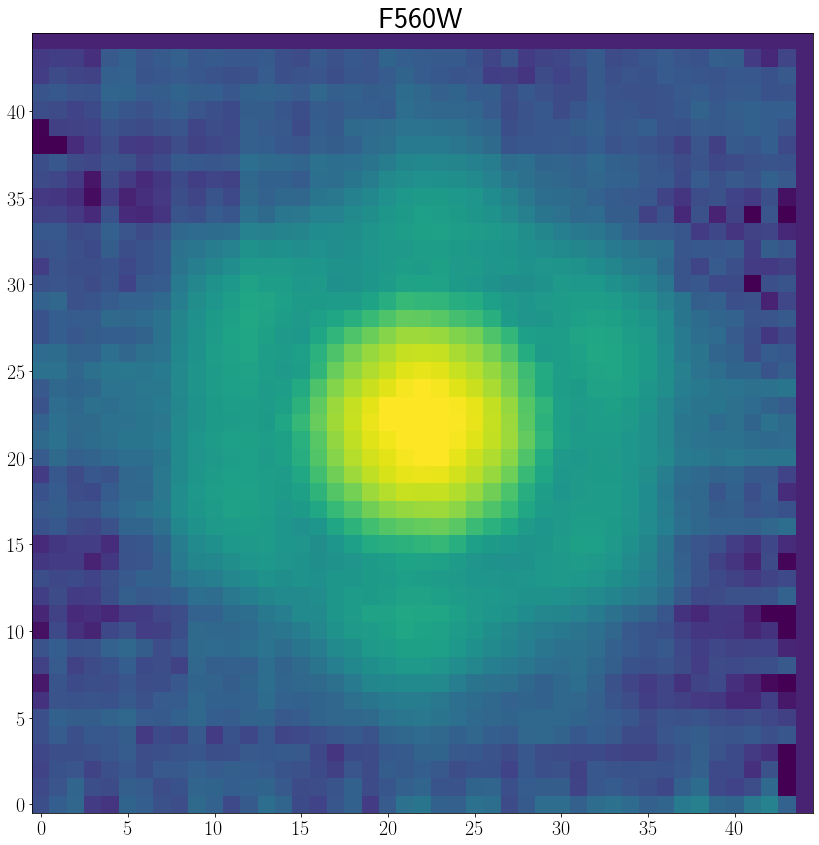

In [44]:
plt.figure(figsize=(12, 12))

ax = plt.subplot(1, 1, 1)

norm_epsf = simple_norm(epsf.data, 'log', percent=99.)
plt.title(filt, fontsize=30)
ax.imshow(epsf.data, norm=norm_epsf)
plt.tight_layout()

6.<font color='white'>-</font>Perform PSF Photometry<a class="anchor" id="psf_phot"></a>
------------------

For general information on PSF Photometry with PhotUtils see [here](https://photutils.readthedocs.io/en/stable/psf.html). 

Photutils provides three classes to perform PSF Photometry: [BasicPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#photutils.psf.BasicPSFPhotometry), [IterativelySubtractedPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.IterativelySubtractedPSFPhotometry.html#photutils.psf.IterativelySubtractedPSFPhotometry), and [DAOPhotPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.DAOPhotPSFPhotometry.html#photutils.psf.DAOPhotPSFPhotometry). Together these provide the core workflow to make photometric measurements given an appropriate PSF (or other) model.

[BasicPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#photutils.psf.BasicPSFPhotometry) implements the minimum tools for model-fitting photometry. At its core, this involves finding sources in an image, grouping overlapping sources into a single model, fitting the model to the sources, and subtracting the models from the image. In DAOPHOT parlance, this is essentially running the “FIND, GROUP, NSTAR, SUBTRACT” once.

[IterativelySubtractedPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.IterativelySubtractedPSFPhotometry.html#photutils.psf.IterativelySubtractedPSFPhotometry) (adopted here) is similar to [BasicPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#photutils.psf.BasicPSFPhotometry), but it adds a parameter called `n_iters` which is the number of iterations for which the loop “FIND, GROUP, NSTAR, SUBTRACT, FIND…” will be performed. This class enables photometry in a scenario where there exists significant overlap between stars that are of quite different brightness. For instance, the detection algorithm may not be able to detect a faint and bright star very close together in the first iteration, but they will be detected in the next iteration after the brighter stars have been fit and subtracted. Like [BasicPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#photutils.psf.BasicPSFPhotometry), it does not include implementations of the stages of this process, but it provides the structure in which those stages run.

**Important parameters**:

* `finder`: classes to find stars in the image. We use [DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html).

* `group_maker`:  clustering algorithm in order to label the sources according to groups. We use [DAOGroup](https://photutils.readthedocs.io/en/stable/api/photutils.psf.DAOGroup.html#photutils.psf.DAOGroup). The method group_stars divides an entire starlist into sets of distinct, self-contained groups of mutually overlapping stars. It accepts as input a list of stars and determines which stars are close enough to be capable of adversely influencing each others’ profile fits. [DAOGroup](https://photutils.readthedocs.io/en/stable/api/photutils.psf.DAOGroup.html#photutils.psf.DAOGroup) aceepts one parameter, `crit_separation`, which is the distance, in units of pixels, such that any two stars separated by less than this distance will be placed in the same group.

* `fitter`: algorithm to fit the sources simultaneously for each group. We use an astropy fitter, [LevMarLSQFitter](https://docs.astropy.org/en/stable/api/astropy.modeling.fitting.LevMarLSQFitter.html#astropy.modeling.fitting.LevMarLSQFitter). 

* `niters`: number of iterations for which the "psf photometry" loop described above is performed.

* `fitshape`: Rectangular shape around the center of a star which will be used to collect the data to do the fitting. 

* `aperture_radius`: The radius (in units of pixels) used to compute initial estimates for the fluxes of sources.

In [45]:
def psf_phot(data=None, det='MIRIM', filt='F560W', th=2000, psf=None, ap_radius=3.5, save_residuals=False, 
             save_output=False):

    fitter = LevMarLSQFitter()
    mmm_bkg = MMMBackground()
        
    sigma_psf = dict_utils[filt]['psf fwhm']
    print('FWHM for filter {f}:'.format(f=filt), sigma_psf*2)
    
    _, std = calc_bkg()
    
    daofind = DAOStarFinder(threshold=th * std, fwhm=sigma_psf)
    
    daogroup = DAOGroup(5.0 * sigma_psf)
    
    psf_model = psf.copy()
    
    print('Performing the PSF photometry --- Detector {d}, filter {f}'.format(f=filt, d=det))
            
    tic = time.perf_counter()
    
    phot = IterativelySubtractedPSFPhotometry(finder=daofind, group_maker=daogroup,
                                              bkg_estimator=mmm_bkg, psf_model=psf_model,
                                              fitter=fitter,
                                              niters=3, fitshape=(11, 11), aperture_radius=ap_radius, 
                                              extra_output_cols=('sharpness', 'roundness2'))
    result = phot(data)
    
    toc = time.perf_counter()
    
    print('Time needed to perform photometry:', '%.2f' % ((toc - tic) / 3600), 'hours')
    print('Number of sources detected:', len(result))
        
    residual_image = phot.get_residual_image()
    
    # save the residual images as fits file:

    if save_residuals:
        hdu = fits.PrimaryHDU(residual_image)
        hdul = fits.HDUList([hdu])
    
        residual_outname = 'residual_%s_%s.fits' % (det, filt)

        hdul.writeto(os.path.join(res_dir, residual_outname))

    # save the output photometry Tables

    if save_output:

        outname = 'phot_%s_%s.pkl' % (det, filt)
        
        tab = result.to_pandas()
        tab.to_pickle(os.path.join(output_phot_dir, outname))
    
    return result, residual_image

In [46]:
data1 = data

output_phot_dir = 'PHOT_OUTPUT/'

if not os.path.exists(output_phot_dir):
    os.makedirs(output_phot_dir)

res_dir = 'RESIDUAL_IMAGES/'

if not os.path.exists(res_dir):
    os.makedirs(res_dir)

if glob.glob(os.path.join(res_dir, 'residual*F560W.fits')):
    print('Deleting Residual images from directory')
    files = glob.glob(os.path.join(res_dir, 'residual*F560W.fits'))
    for file in files:
        os.remove(file)

psf_phot_results, residual_image = psf_phot(data=data1, det=det, filt=filt, th=10, psf=psf_webbpsf_grid, 
                                            save_residuals=True, save_output=True)

2022-03-30 14:38:55,973 - stpipe - WARNING - /Users/ofox/miniconda3/envs/jwebbinar/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



FWHM for filter F560W: 3.272


2022-03-30 14:38:56,180 - stpipe - WARNING - /Users/ofox/miniconda3/envs/jwebbinar/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '

2022-03-30 14:38:56,419 - stpipe - WARNING - /Users/ofox/miniconda3/envs/jwebbinar/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



Performing the PSF photometry --- Detector MIRIM, filter F560W


2022-03-30 14:39:14,642 - stpipe - WARNING - /Users/ofox/miniconda3/envs/jwebbinar/lib/python3.8/site-packages/astropy/modeling/fitting.py:1169: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-03-30 14:39:29,685 - stpipe - WARNING - /Users/ofox/miniconda3/envs/jwebbinar/lib/python3.8/site-packages/astropy/modeling/fitting.py:1169: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-03-30 14:39:35,457 - stpipe - WARNING - /Users/ofox/miniconda3/envs/jwebbinar/lib/python3.8/site-packages/astropy/modeling/fitting.py:1169: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "



Time needed to perform photometry: 0.01 hours
Number of sources detected: 983


### 6.1<font color='white'>-</font>PSF photometry output catalog<a class="anchor" id="psf_cat"></a> ###

In [47]:
psf_phot_results

<QTable length=983>
       x_0               x_fit               y_0               y_fit        ...       flux_unc            x_0_unc              y_0_unc        iter_detected
     float64            float64            float64            float64       ...       float64             float64              float64            int64    
------------------ ------------------ ------------------ ------------------ ... ------------------- -------------------- -------------------- -------------
 676.5836963370951  676.4546046398015  9.163241766911698  9.147036843046363 ...  0.6882224112711329 0.008162874649114613 0.008656709313256935             1
459.61327571403046   459.464441977234  9.691173024376367  9.739776809951865 ...  0.4782246814930431 0.018091201833167377 0.019292208285789533             1
 597.8626249117399   597.894396596936 10.034624536597038 10.027645918187705 ...  0.6012043161062235 0.036189962159264344  0.03793935572646672             1
 990.3551135064819  990.5345989162972 11.901355690484671 11.893315428312327 ...  0.7273162859253551 0.009801854853001786 0.010303745566405367             1
 650.2394456591585  650.5024647189177 13.774594833196794 13.802457180676718 ...  0.5552780590920621  0.06496794035867243  0.06877972423184532             1
  616.443628285548  616.3815340781656  16.52481712010206 16.430927965133485 ...   5.109677172704402 0.021710698801839436 0.022793953519038245             1
 980.3595456352251  980.2499768677252 17.818670416879403 17.782318682695546 ...  10.158776960084253   1.8887211808569404   1.9724948070390458             1
  984.423366673339  984.3633889837538    23.314763264579  23.24894151842949 ...  10.166781077436887   0.2717930541435021  0.28398966638525563             1
  743.913450508919  743.9038838104605  19.05060531875447 19.024298916686597 ... 0.28959825259552346  0.06416302228618363  0.06685270122721472             1
 755.2438631841759  755.2434310055637  19.83549756822631 19.847636586642725 ...  0.4563702435419051  0.07170027312045264  0.07542066948709628             1
 942.5887594431498  942.6858548446211   20.0193000258344 19.995376553314227 ... 0.22239959649277466 0.019398648228988492 0.020280526399509644             1
 466.7420356541888  466.7775629122002 22.399993373776173 22.336715631662575 ...  2.0477716846075658 0.004484665191677112 0.004693563310077491             1
 525.3621671591897   525.303510231286 22.035861631907498 22.035535990355555 ...  0.4247675666185583 0.021163365368707183 0.022560717443760283             1
 475.6580836048535  475.6580836048535 22.366353688561116 22.366353688561116 ...  0.6933421963844333  0.00954241009447487 0.009990899881433287             1
               ...                ...                ...                ... ...                 ...                  ...                  ...           ...
113.94788179023494 110.43070203062308  843.8436306501443  844.3176603397254 ...                  --                   --                   --             3
118.89764456203912 119.02637700564725  848.6253853883331  848.5815663011555 ...                  --                   --                   --             3
113.46505265067982 113.57495238850599  848.2334009407709  848.6911662470532 ...                  --                   --                   --             3
123.04811318735868 122.81168968161704   851.067959581753  850.9313724827985 ...                  --                   --                   --             3
 660.2058745365781  659.4279638462577  850.0665542562086  848.4448030633284 ...                  --                   --                   --             3
 663.4439994747939  663.7662247547104  847.1669169877106  847.5992024713402 ...                  --                   --                   --             3
  808.946045714071   808.670664559377  900.9929124162026  898.8004684498358 ...                  --                   --                   --             3
200.05197048721223 202.24129051264694   926.421301054303  927.8282690457976 ... 

### 6.2<font color='white'>-</font>Display residual image<a class="anchor" id="residual"></a> ###

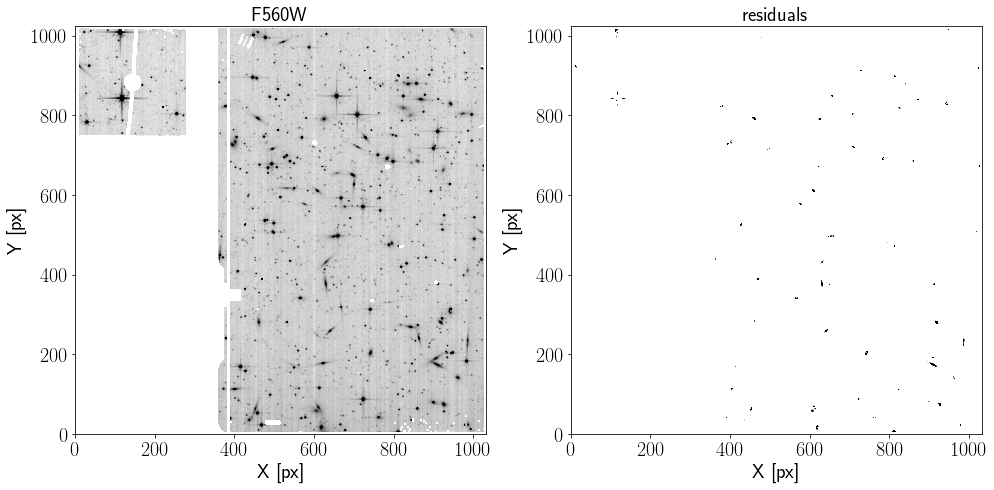

In [48]:
plt.figure(figsize=(14, 14))

ax1 = plt.subplot(2, 2, 1)

plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.title(filt, fontdict=font2)

norm = simple_norm(data1, 'sqrt', percent=99.)
ax1.imshow(data1, norm=norm, cmap='Greys')

ax2 = plt.subplot(2, 2, 2)

plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.title('residuals', fontdict=font2)

norm = simple_norm(data1, 'sqrt', percent=90.)
ax2.imshow(residual_image, norm=norm, cmap='Greys')

#ax3 = plt.subplot(2, 2, 3)
#
#plt.xlabel("X [px]", fontdict=font2)
#plt.ylabel("Y [px]", fontdict=font2)
#plt.title(filt, fontdict=font2)
#
#norm = simple_norm(data, 'sqrt', percent=99.)
#ax3.imshow(data, norm=norm, cmap='Greys')
#
#ax4 = plt.subplot(2, 2, 4)
#
#if os.path.isfile('./RESIDUAL_IMAGES/residual_MIRIM_F560W.fits'):
#    res_f560w = './RESIDUAL_IMAGES/residual_MIRIM_F560W.fits'
#
#else:
#    print('Downloading F560W residual image')
#    
#    boxlink_res_f115w = 'https://stsci.box.com/shared/static/g4ffi7zowwlj91up4nkqxz38c1l4tpjx.fits'
#    boxfile_res_f115w = './residual_webbpsf_grid16_NRCB1_F115W.fits'
#    urllib.request.urlretrieve(boxlink_res_f115w, boxfile_res_f115w)
#    res_f115w = boxfile_res_f115w
#
#if os.path.isfile('./residual_webbpsf_grid16_NRCB1_F200W.fits'):
#    res_f200w = './residual_webbpsf_grid16_NRCB1_F200W.fits'
#
#else:
#    print('Downloading F200W residual image')
#    
#    boxlink_res_f200w = 'https://stsci.box.com/shared/static/mssn25cokiwfwco9f289nds7lennfgvv.fits'
#    boxfile_res_f200w = './residual_webbpsf_grid16_NRCB1_F200W.fits'
#    urllib.request.urlretrieve(boxlink_res_f200w, boxfile_res_f200w)
#    res_f200w = boxfile_res_f200w
#
#residual = res_f560w
#
#residual = fits.open(residual)
#res_data = residual[0].data
#
#plt.xlabel("X [px]", fontdict=font2)
#plt.ylabel("Y [px]", fontdict=font2)
#plt.title('residuals', fontdict=font2)
#
#ax4.imshow(res_data, norm=norm, cmap='Greys')

plt.tight_layout()

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>